**1. Przetwarzanie konturu na obraz rastrowy**

Wczytywanie przykładowych plików

In [2]:
#parametry

imside = 28
padding = 3

In [7]:
import os
import math

vectors = []
maximum_xs = []
maximum_ys = []
minimum_xs = []
minimum_ys = []
i = 0

directory = "data/Contours/7"

for filename in os.listdir(directory):
    
    vectors.append([])
    f = open(directory + "/" + filename, "r")
    maximum_xs.append(-math.inf)
    maximum_ys.append(-math.inf)
    minimum_xs.append(math.inf)
    minimum_ys.append(math.inf)
    
    for line in f.readlines():
        line = line[:-1]
        coords = line.split(' ')
#transformacje związane z obróceniem tablicy w środowisku (powinno być trochę bardziej elegancko :?)
        vectors[i].append([float(coords[0]), -float(coords[1])])
        if (maximum_xs[i] < float(coords[0])):
            maximum_xs[i] = float(coords[0])
        if (maximum_ys[i] < -float(coords[1])):
            maximum_ys[i] = -float(coords[1])
        if (minimum_xs[i] > float(coords[0])):
            minimum_xs[i] = float(coords[0])
        if (minimum_ys[i] > -float(coords[1])):
            minimum_ys[i] = -float(coords[1])
    i = i + 1

num_of_pics = i
print(vectors[0])

ValueError: could not convert string to float: ''

In [4]:
num_of_pics

NameError: name 'num_of_pics' is not defined

Następnie normalizacja:

In [5]:
imrange = imside - 2*padding
i = 0
norms = []

for v in vectors:
    range_x = maximum_xs[i] - minimum_xs[i]
    range_y = maximum_ys[i] - minimum_ys[i]

    maxrange = max(range_x , range_y)
    if maxrange == 0:
        norms.append([[imside/2, imside/2]])
        i += 1
        continue
    ratio =  min(range_x, range_y) / maxrange
    
    if (range_x > range_y):
        norms.append([[(vector[0]-minimum_xs[i])*imrange/maxrange + padding,
                        (vector[1]-minimum_ys[i])*imrange/maxrange + padding + imrange*(1-ratio)/2] for vector in v])
    else:
        norms.append([[(vector[0]-minimum_xs[i])*imrange/maxrange + padding + imrange*(1-ratio)/2,
                        (vector[1]-minimum_ys[i])*imrange/maxrange + padding] for vector in v])
        
    i = i + 1

NameError: name 'vectors' is not defined

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

fig = plt.figure(figsize=(30, 8*num_of_pics))
i = 1

for norm in norms:
    img = 255 * np.ones([imside,imside], dtype=np.uint8)
    for point in norm:
        img[int(point[0])][int(point[1])] = 0
    plot = fig.add_subplot(num_of_pics,5,i)
    plot.imshow(img,cmap='gray')
    i = i + 1

plt.show()


NameError: name 'num_of_pics' is not defined

Obliczam współczynniki dla parametrycznych krzywych Béziera

In [ ]:
# find the a & b points
def get_bezier_coef(points):
    # since the formulas work given that we have n+1 points
    # then n must be this:
    n = len(points) - 1

    # build coefficents matrix
    C = 4 * np.identity(n)
    np.fill_diagonal(C[1:], 1)
    np.fill_diagonal(C[:, 1:], 1)
    C[0, 0] = 2
    C[n - 1, n - 1] = 7
    C[n - 1, n - 2] = 2

    # build points vector
    P = [2 * (2 * points[i] + points[i + 1]) for i in range(n)]
    P[0] = points[0] + 2 * points[1]
    P[n - 1] = 8 * points[n - 1] + points[n]

    # solve system, find a & b
    A = np.linalg.solve(C, P)
    B = [0] * n
    for i in range(n - 1):
        B[i] = 2 * points[i + 1] - A[i + 1]
    B[n - 1] = (A[n - 1] + points[n]) / 2

    return A, B

# returns the general Bezier cubic formula given 4 control points
def get_cubic(a, b, c, d):
    return lambda t: np.power(1 - t, 3) * a + 3 * np.power(1 - t, 2) * t * b + 3 * (1 - t) * np.power(t, 2) * c + np.power(t, 3) * d

# return one cubic curve for each consecutive points
def get_bezier_cubic(points):
    A, B = get_bezier_coef(points)
    return [
        get_cubic(points[i], A[i], B[i], points[i + 1])
        for i in range(len(points) - 1)
    ]

# evalute each cubic curve on the range [0, 1] sliced in n points
def evaluate_bezier(points, n):
    curves = get_bezier_cubic(points)
    return np.array([fun(t) for fun in curves for t in np.linspace(0, 1, n)])

In [9]:
points = np.array(norms[0])
path = evaluate_bezier(points, 50)

# extract x & y coordinates of points
x, y = points[:,0], points[:,1]
px, py = path[:,0], path[:,1]

# plot
plt.figure(figsize=(11, 11))
plt.plot(px, py, 'b-')
plt.plot(x, y, 'ro')
plt.show()

IndexError: list index out of range

In [ ]:
import numpy as np
from skimage import io

brush_size = 2
factor = -(2.0/brush_size)**2

imgs = []

fig = plt.figure(figsize=(30, 8*num_of_pics))
i = 1

def draw_pixel(img, x, y, val):
    if (x < 0 or x >= imside or y <0 or y >= imside):
        return
    if (255 - img[x][y] > val):
        img[x][y] += val
    else:
        img[x][y] = 255

def draw_dot(img, x, y):
    for ox in range(-brush_size,brush_size+1):
        for oy in range(-brush_size,brush_size+1):
            draw_pixel(img, x+ox, y+oy, 20*math.exp( factor * (ox**2 + oy**2)))
        
for norm in norms:
    img = 255 * np.zeros([imside,imside], dtype=np.uint8)
    
    if (len(norm) == 1):
        draw_dot(img, int(norm[0][0]), int(norm[0][1]))
    else:    
        path = evaluate_bezier(np.array(norm), 50)
        px, py = path[:,0], path[:,1]
        n = len(px)
        for index in range(n):
            draw_dot(img, int(px[index]), int(py[index]))
            
    plot = fig.add_subplot(num_of_pics,5,i)
    plot.imshow(img,cmap='Greys')
    imgs.append(img)
    i += 1

plt.show()

**2. Klasyfikacja obrazów**

Pobieram zbiór danych MNIST

In [9]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

0


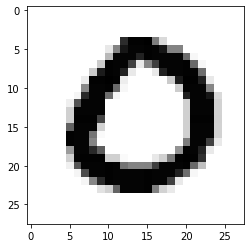

In [10]:
image_index = 429 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

In [12]:
x_train.shape

(60000, 28, 28)

In [13]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [14]:
# Importing the required Keras modules containing model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [15]:
model.layers

In [16]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3498 - accuracy: 0.8972
Epoch 2/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0854 - accuracy: 0.9751
Epoch 3/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0560 - accuracy: 0.9827
Epoch 4/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0425 - accuracy: 0.9864
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0320 - accuracy: 0.9902
Epoch 6/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0265 - accuracy: 0.9910
Epoch 7/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0251 - accuracy: 0.9913
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0202 - accuracy: 0.9930
Epoch 9/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0176 - accuracy: 0.9937
Epoch 10/10
1875/1875 [==============================] - 14s 8ms/step - l

In [18]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0633 - accuracy: 0.9855


[0.06334307044744492, 0.9854999780654907]

In [124]:
for img in imgs:
    pred = model.predict(img.reshape(1, 28, 28, 1))
    print(pred.argmax())

3
9
2
3
4
3
6
3
8
3


In [107]:
model.evaluate(np.array(imgs).reshape(np.array(imgs).shape[0],imside,imside,1), np.zeros(num_of_pics))

4/4 [==============================] - 0s 3ms/step - loss: 683.5530 - accuracy: 0.8586


[683.552978515625, 0.8585858345031738]

:(((

In [82]:
np.array(range(-2,2))

array([-2, -1,  0,  1])

In [86]:
math.exp(2)

7.38905609893065